In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import sys

## initial setup

In [2]:
import numpy as np
from math import exp
from random import random, uniform, randrange
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(200)
# grid world length
N = 50

# goal_x, goal_y: coordinate for final termination
goal_x = 0
goal_y = 9

# states and congestion probability matrix
states = np.zeros((N,N))
# up down left right
conge_prob = np.zeros((N,N,4))
conge_weight = np.zeros((N,N,4))

occur_prob = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
for i in range(N):
	for j in range(N):
		conge_prob[i,j] =  np.random.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], size=4)

for i in range(N):
	for j in range(N):
		for k in range(4):
			conge_weight[i,j,k] = 1/conge_prob[i,j,k]
			# set the boundaries to 0
			if i == 0 and k == 0 :
				conge_weight[i,j,k] = 0
			if j == 0 and k == 2 :
				conge_weight[i,j,k] = 0
			if i == 49 and k == 1 :
				conge_weight[i,j,k] = 0
			if j == 49 and k == 3 :
				conge_weight[i,j,k] = 0

## System of Equation

In [13]:
def min_cost(Conge_weight, n, Goal_x, Goal_y):
	# (Cost to goal coordinate, previous action)
  mincost_matrix = np.zeros((n,n,2))
  mincost_matrix[0,9,0] = 0
  mincost_present = np.zeros(((n,n)))
  loop = 0
  not_change = 0
  while loop < 2502:
    matrix_tmp = np.array(mincost_matrix)
    loop +=1
    for i in range (n):
      for j in range (n):
        if i == Goal_x and j == Goal_y:
          mincost_matrix[i,j,0] = 0
          mincost_present[i,j] = 0
        else:
          cost = np.array([])
          next_action = np.array([])
          if i != 0 :
            cost = np.append(cost, matrix_tmp[i-1,j,0] + Conge_weight[i-1,j,0])
            next_action = np.append(next_action,0)
          if i != N-1 :
            cost = np.append(cost, matrix_tmp[i+1,j,0] + Conge_weight[i+1,j,1])
            next_action = np.append(next_action, 1)
          if j != 0 :
            cost = np.append(cost, matrix_tmp[i,j-1,0] + Conge_weight[i,j-1,2])
            next_action = np.append(next_action, 2)
          if j != N-1 : 
            cost = np.append(cost, matrix_tmp[i,j+1,0] + Conge_weight[i,j+1,3])
            next_action = np.append(next_action, 3)
          
          mincost_matrix[i,j,0] = np.min(cost)
          mincost_present[i,j] = np.min(cost)
          key = np.argmin(cost)
          try:
            mincost_matrix[i,j,1] = next_action[key]
          except:
            print("len of cost", len(cost))
            print("error")
            break


    #print("step: ", loop)
    if np.array_equal(matrix_tmp , mincost_matrix):
      not_change +=1
      if not_change == 50:
        break
  return mincost_matrix, mincost_present

In [14]:
%%time
mincost, mincost_pres = min_cost(conge_weight, N, goal_x, goal_y)

CPU times: user 46.2 s, sys: 2.22 ms, total: 46.2 s
Wall time: 46.2 s


In [15]:
print(mincost_pres)

[[ 14.56349206  13.13492063  10.63492063 ...  70.11111111  73.44444444
   74.55555556]
 [ 14.56349206  13.13492063  10.63492063 ...  69.44444444  73.44444444
   74.55555556]
 [ 15.37301587  12.03968254   9.53968254 ...  72.77777778  76.11111111
   77.22222222]
 ...
 [ 83.59126984  82.59126984  81.8968254  ... 112.58730159 115.09920635
  116.09920635]
 [ 85.25793651  84.32539683  83.32539683 ... 112.25396825 113.25396825
  114.50396825]
 [ 86.25793651  85.57539683  84.75396825 ... 113.36507937 114.61507937
  115.72619048]]


In [5]:
def route_mincost(start_x, start_y, Goal_x, Goal_y, Mincost):
  x = [start_x]
  y = [start_y]
  while start_x != Goal_x or start_y != Goal_y:
    if Mincost[start_x, start_y, 1] == 0:
      start_x -= 1
    elif Mincost[start_x, start_y, 1] == 1:
      start_x += 1
    elif Mincost[start_x, start_y, 1] == 2:
      start_y -= 1
    elif Mincost[start_x, start_y, 1] == 3:
      start_y += 1

    x.append(start_x)
    y.append(start_y)

  return x, y


Text(0.5, 1.0, 'Move procedure from (49,49)')

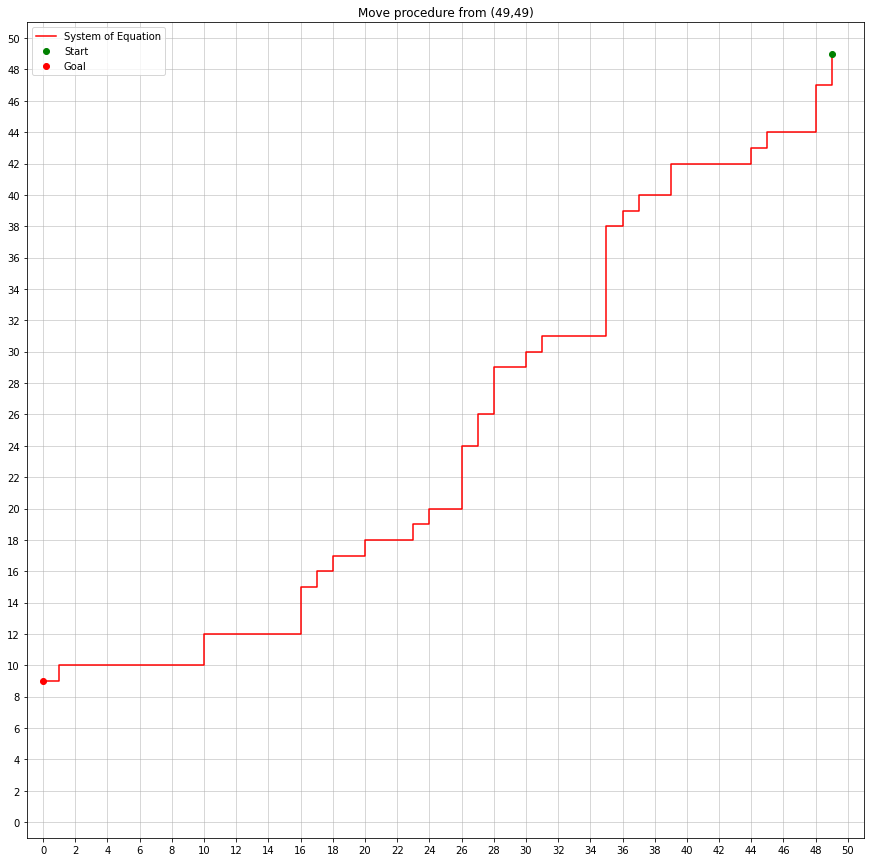

In [6]:
# plot system of equation
ini_state = (49,49)
X, Y = route_mincost(ini_state[0],ini_state[1],goal_x,goal_y, mincost)

plt.figure(figsize=(15,15))
plt.grid(True, linewidth=0.5, linestyle='-')
plt.xlim((-1,51))
plt.ylim((-1,51))
plt.xticks(np.arange(0, 51, step=2))
plt.yticks(np.arange(0, 51, step=2))
plt.plot(X, Y, color= 'red', label = 'System of Equation')
plt.plot(ini_state[0], ini_state[1], 'go', label = 'Start')
plt.plot(goal_x, goal_y, 'ro', label = 'Goal')
plt.legend()
plt.title("Move procedure from (49,49)")

## Simple Heuristic

In [7]:
def Heuristic_plot(Goal_x, Goal_y, start_x, start_y, Conge_cost):
  x = [start_x]
  y = [start_y]
  i = start_x
  j = start_y
  total_cost = 0
  while i != Goal_x or j != Goal_y:
    moves = np.array([])
    move_cost = np.array([])
    # pick the min move from all possible moves
    if i < Goal_x and i != N-1:
      moves = np.append(moves, 1) # down
      move_cost = np.append(move_cost, Conge_cost[i,j,1])
    if i > Goal_x and i != 0:
      moves = np.append(moves, 0) # up
      move_cost = np.append(move_cost, Conge_cost[i,j,0])
    if j < Goal_y and j != N-1:
      moves = np.append(moves, 3) # right
      move_cost = np.append(move_cost, Conge_cost[i,j,3])
    if j > Goal_y and j != 0:
      moves = np.append(moves, 2) # left
      move_cost = np.append(move_cost, Conge_cost[i,j,2])
    
    min_move_cost = np.min(move_cost)
    min_key = np.argmin(move_cost)
    # calculate the cost so far
    total_cost += min_move_cost
    
    # update the location
    move = moves[min_key]
    if move == 1:
      i = i+1
    elif move == 0:
      i = i-1
    elif move == 3:
      j = j+1
    elif move == 2:
      j = j-1
    
    x.append(i)
    y.append(j)
  H_cost = total_cost

  return x,y,H_cost



Text(0.5, 1.0, 'Move procedure from (49,49)')

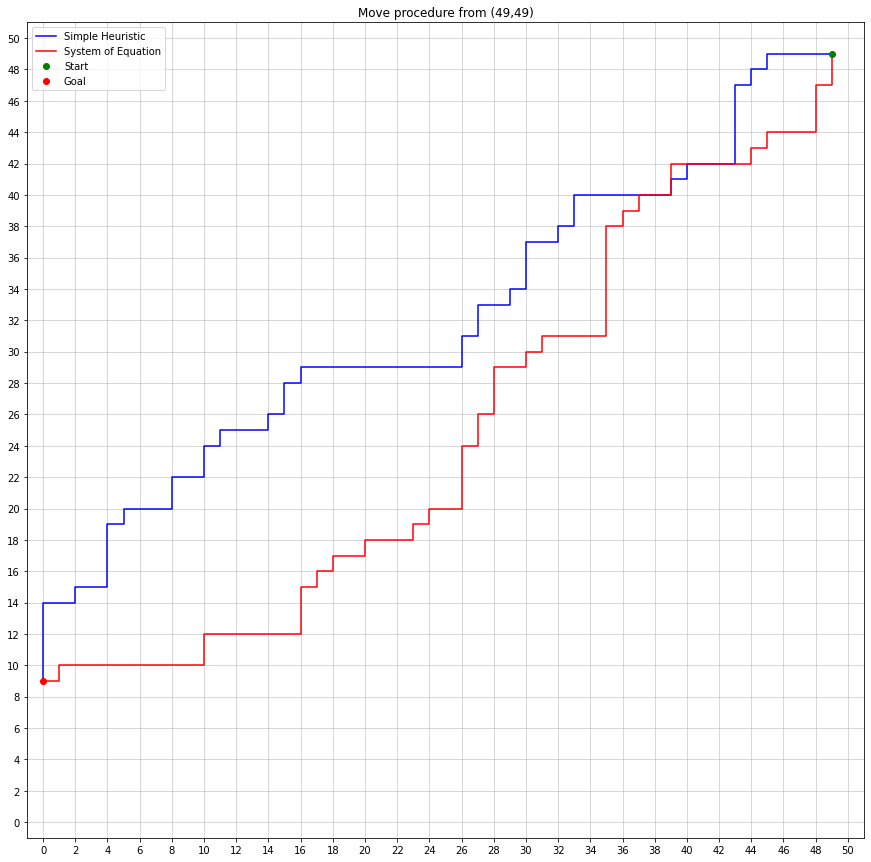

In [8]:
ini_state = (49,49)
X_h, Y_h, h_cost = Heuristic_plot(goal_x,goal_y,ini_state[0],ini_state[1],conge_weight)
plt.figure(figsize=(15,15))
plt.grid(True, linewidth=0.5, linestyle='-')
plt.xlim((-1,51))
plt.ylim((-1,51))
plt.xticks(np.arange(0, 51, step=2))
plt.yticks(np.arange(0, 51, step=2))
plt.plot(X_h, Y_h, color= 'blue', label = 'Simple Heuristic')
plt.plot(X, Y, color= 'red', label = 'System of Equation')
plt.plot(ini_state[0], ini_state[1], 'go', label = 'Start')
plt.plot(goal_x, goal_y, 'ro', label = 'Goal')
plt.legend()
plt.title("Move procedure from (49,49)")

In [42]:
print(h_cost)

156.17857142857144


## 2nd Q learning Plot

In [9]:
# Q learning

def findMaxQ(Q, x, y, Moves):
    q_max = -1000000
    move_dec = 0
    # print("moves in function: ",Moves)
    for mv in Moves:
        mv_i = int(mv)
        # print(Q[x,y,mv_i])
        if Q[x, y, mv_i] >= q_max:
            q_max = Q[x, y, mv_i]
            move_dec = mv_i
    return [move_dec, q_max]

def move(i, j, action):
    indicator = np.random.choice([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], size=1)
    r = 0
    action = int(action)
    if indicator <= conge_prob[i, j, action]:
        if action == 0:
            next_state_x = i - 1
            next_state_y = j
        elif action == 1:
            next_state_x = i + 1
            next_state_y = j
        elif action == 2:
            next_state_x = i
            next_state_y = j - 1
        elif action == 3:
            next_state_x = i
            next_state_y = j + 1
        if (next_state_y == 9) and (next_state_x == 0):
            r = 1
        return next_state_x, next_state_y, r
    else:
        return i, j, r


def QLearning(Goal_x, Goal_y, Q, Simu_t, Simu_vec, Conge_cost, Lr=0.1, Eps=0.99, Eps_decay=0.005, Gamma=0.99):
    Q_cost = np.array([])

    for t in range(Simu_t):
        print("simu time :", t)
        print("start coordinate: ", Simu_vec[t])
        i = int(Simu_vec[t, 0])
        j = int(Simu_vec[t, 1])
        total_cost = 0
        total_step = 0

        if Eps > 0.01:
            Eps -= Eps_decay
        if Lr > 0.01:
            Lr -= 0.0001

        while i != Goal_x or j != Goal_y:
            Qtmp = np.array(Q)
            moves = np.array([])
            move_cost = np.array([])

            flag = 0
            # possible moves:
            if i != N - 1:
                moves = np.append(moves, 1)  # down
                move_cost = np.append(move_cost, Conge_cost[i, j, 1])
            if i != 0:
                moves = np.append(moves, 0)  # up
                move_cost = np.append(move_cost, Conge_cost[i, j, 0])
            if j != N - 1:
                moves = np.append(moves, 3)  # right
                move_cost = np.append(move_cost, Conge_cost[i, j, 3])
            if j != 0:
                moves = np.append(moves, 2)  # left
                move_cost = np.append(move_cost, Conge_cost[i, j, 2])

            # explore
            random_pick = np.random.rand()
            if Eps > random_pick:
                next_move = np.random.choice(moves)

            # exploit
            else:
                # print("======= Exploit Q =======")
                Q_val = findMaxQ(Qtmp, i, j, moves)
                next_move = Q_val[0]
                flag = 1

            # update location by move
            next_loc = move(i, j, next_move)

            # possible moves for next state
            moves_next_state = np.array([])
            if next_loc[0] != N - 1:
                moves_next_state = np.append(moves_next_state, 1)  # down

            if next_loc[0] != 0:
                moves_next_state = np.append(moves_next_state, 0)  # up

            if next_loc[1] != N - 1:
                moves_next_state = np.append(moves_next_state, 3)  # right

            if next_loc[1] != 0:
                moves_next_state = np.append(moves_next_state, 2)  # left

            # the reward (cost) which would be use in the following formula
            next_move_i = int(next_move)

            # Q(t+1, a)
            # print("current loc", i,j)
            # print("possible moves ", moves)
            # print("next move: ", next_move_i)
            # print("0 for explore , 1 for exploit: ", flag)


            Q_val_next = findMaxQ(Qtmp, next_loc[0], next_loc[1], moves_next_state)
            r = next_loc[2]
            # Update Q

            Q[i, j, next_move_i] = (1 - Lr) * Qtmp[i, j, next_move_i] + Lr * (r + Gamma * Q_val_next[1])
            total_cost += 1

            i = next_loc[0]
            j = next_loc[1]

            total_step += 1

        Q_cost = np.append(Q_cost, total_cost)
        print("total cost: ", total_cost)
        print("total step: ", total_step)

    return Q_cost, Q
  


### fixed 49,49

In [12]:
%%time
# fix start point 49,49
Q_vec = np.zeros((N, N, 4))

simulation_size = 2500
simulation_array = np.zeros((simulation_size, 2))
for i in range(simulation_size):
  simulation_array[i,0] = 49
  simulation_array[i,1] = 49

qlearning_cost_fix, New_Qfix = QLearning(goal_x, goal_y, Q_vec, simulation_size, simulation_array, conge_weight)

Streaming output truncated to the last 5000 lines.
total cost:  192
total step:  192
simu time : 1251
start coordinate:  [49. 49.]
total cost:  182
total step:  182
simu time : 1252
start coordinate:  [49. 49.]
total cost:  182
total step:  182
simu time : 1253
start coordinate:  [49. 49.]
total cost:  188
total step:  188
simu time : 1254
start coordinate:  [49. 49.]
total cost:  198
total step:  198
simu time : 1255
start coordinate:  [49. 49.]
total cost:  192
total step:  192
simu time : 1256
start coordinate:  [49. 49.]
total cost:  204
total step:  204
simu time : 1257
start coordinate:  [49. 49.]
total cost:  222
total step:  222
simu time : 1258
start coordinate:  [49. 49.]
total cost:  189
total step:  189
simu time : 1259
start coordinate:  [49. 49.]
total cost:  173
total step:  173
simu time : 1260
start coordinate:  [49. 49.]
total cost:  178
total step:  178
simu time : 1261
start coordinate:  [49. 49.]
total cost:  185
total step:  185
simu time : 1262
start coordinate: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

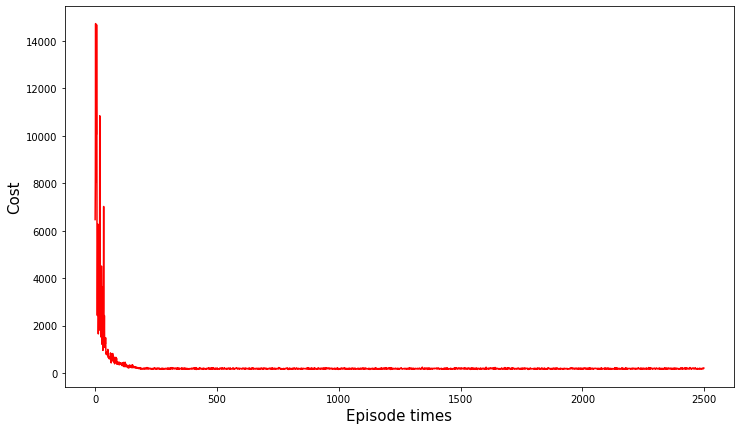

In [41]:
plt.figure(figsize=(12,7))
plt.plot(qlearning_cost_fix,'r-')
#plt.plot(qlearning_cost_fix,'b.')
plt.xlabel("Episode times", fontsize = 15)
plt.ylabel("Cost", fontsize = 15)


plt.savefig("qlearning.png", dpi = 300)
from google.colab import files
files.download("qlearning.png")


### random start

In [11]:
%%time
Q_vec = np.zeros((N, N, 4))
simulation_size = 10000
simulation_array = np.zeros((simulation_size,2))
for i in range(simulation_size):
  simulation_array[i] = np.random.choice(49,2)

qlearning_cost_ran, New_Q_ran = QLearning(goal_x, goal_y, Q_vec, simulation_size, simulation_array, conge_weight)

Streaming output truncated to the last 5000 lines.
total cost:  128
total step:  128
simu time : 8751
start coordinate:  [32. 33.]
total cost:  127
total step:  127
simu time : 8752
start coordinate:  [26. 13.]
total cost:  79
total step:  79
simu time : 8753
start coordinate:  [35. 31.]
total cost:  138
total step:  138
simu time : 8754
start coordinate:  [13. 16.]
total cost:  38
total step:  38
simu time : 8755
start coordinate:  [26. 47.]
total cost:  165
total step:  165
simu time : 8756
start coordinate:  [ 9. 21.]
total cost:  46
total step:  46
simu time : 8757
start coordinate:  [ 2. 41.]
total cost:  79
total step:  79
simu time : 8758
start coordinate:  [24. 14.]
total cost:  77
total step:  77
simu time : 8759
start coordinate:  [33. 37.]
total cost:  142
total step:  142
simu time : 8760
start coordinate:  [38. 27.]
total cost:  136
total step:  136
simu time : 8761
start coordinate:  [23.  4.]
total cost:  50
total step:  50
simu time : 8762
start coordinate:  [35. 25.]
t

In [33]:
def Q_step(Q, Goal_x, Goal_y, start_x, start_y):
  Eps = 0.01
  Lr = 0.01
  Gamma = 0.99
  i = start_x
  j = start_y

  x = [start_x]
  y = [start_y]
  total_step = 0
  total_cost = 0

  while i != Goal_x or j != Goal_y:
    Qtmp = np.array(Q)
    moves = np.array([])
   

    flag = 0
    # possible moves:
    if i != N - 1:
        moves = np.append(moves, 1)  # down
        
    if i != 0:
        moves = np.append(moves, 0)  # up
        
    if j != N - 1:
        moves = np.append(moves, 3)  # right
       
    if j != 0:
        moves = np.append(moves, 2)  # left
       

    # explore
    random_pick = np.random.rand()
    if Eps > random_pick:
        next_move = np.random.choice(moves)

    # exploit
    else:
        # print("======= Exploit Q =======")
        Q_val = findMaxQ(Qtmp, i, j, moves)
        next_move = Q_val[0]
        flag = 1

    # update location by move
    next_loc = move(i, j, next_move)

    # possible moves for next state
    moves_next_state = np.array([])
    if next_loc[0] != N - 1:
        moves_next_state = np.append(moves_next_state, 1)  # down

    if next_loc[0] != 0:
        moves_next_state = np.append(moves_next_state, 0)  # up

    if next_loc[1] != N - 1:
        moves_next_state = np.append(moves_next_state, 3)  # right

    if next_loc[1] != 0:
        moves_next_state = np.append(moves_next_state, 2)  # left

    # the reward (cost) which would be use in the following formula
    next_move_i = int(next_move)

    # Q(t+1, a)
    # print("current loc", i,j)
    # print("possible moves ", moves)
    # print("next move: ", next_move_i)
    # print("0 for explore , 1 for exploit: ", flag)


    Q_val_next = findMaxQ(Qtmp, next_loc[0], next_loc[1], moves_next_state)
    r = next_loc[2]
    # Update Q

    Q[i, j, next_move_i] = (1 - Lr) * Qtmp[i, j, next_move_i] + Lr * (r + Gamma * Q_val_next[1])
    
    if i!= next_loc[0] or j!= next_loc[1]:
      tmp_cost = conge_weight[i,j,next_move_i]
      total_cost += tmp_cost


    i = next_loc[0]
    j = next_loc[1]

    x.append(i)
    y.append(j)

    total_step += 1
  
  return x, y, total_step, total_cost


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 1.5 s, sys: 30.9 ms, total: 1.53 s
Wall time: 1.53 s


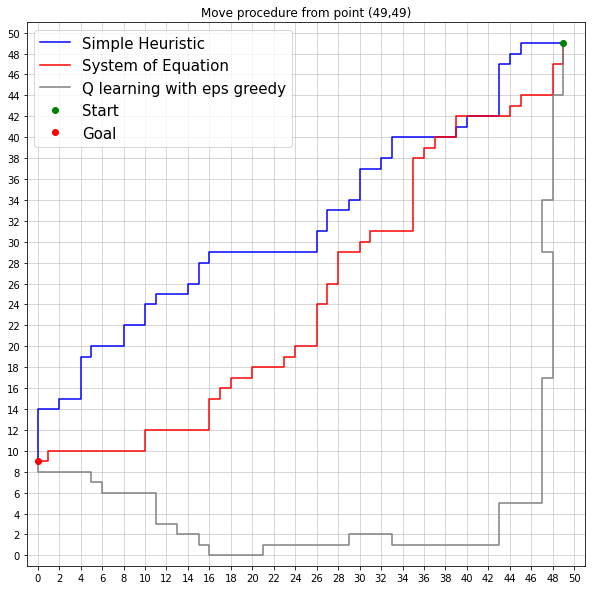

In [40]:
%%time
X_q, Y_q, q_coststep, q_weightcost = Q_step(New_Qfix, goal_x, goal_y, ini_state[0],ini_state[1])
plt.figure(figsize=(10,10))
plt.grid(True, linewidth=0.5, linestyle='-')
plt.xlim((-1,51))
plt.ylim((-1,51))
plt.xticks(np.arange(0, 51, step=2))
plt.yticks(np.arange(0, 51, step=2))
plt.plot(X_h, Y_h, color= 'blue', label = 'Simple Heuristic')
plt.plot(X, Y, color= 'red', label = 'System of Equation')
plt.plot(X_q, Y_q, color ='grey', label = "Q learning with eps greedy")
plt.plot(ini_state[0], ini_state[1], 'go', label = 'Start')
plt.plot(goal_x, goal_y, 'ro', label = 'Goal')
plt.legend( fontsize=15)
plt.title("Move procedure from point (49,49)")

plt.savefig("Move_procedure.png", dpi = 300)
from google.colab import files
files.download("Move_procedure.png")



In [60]:
print(q_weightcost)
print(q_coststep)
print(mincost[49,49])
print(h_cost)

191.1666666666666
195
[115.72619048   2.        ]
156.17857142857144
